# Gannon University - Statistical Computing
Course Project - Spam Filter

## Import packages and libraries

In [153]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import plotly.express as px
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load dataset

In [15]:
df = pd.read_csv('/content/drive/MyDrive/Gannon/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [17]:
df = df.drop(df[["Unnamed: 2","Unnamed: 3","Unnamed: 4"]], axis=1)
df.rename(columns = {"v1":"class", "v2":"text"}, inplace = True)
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data cleaning and feature extraction




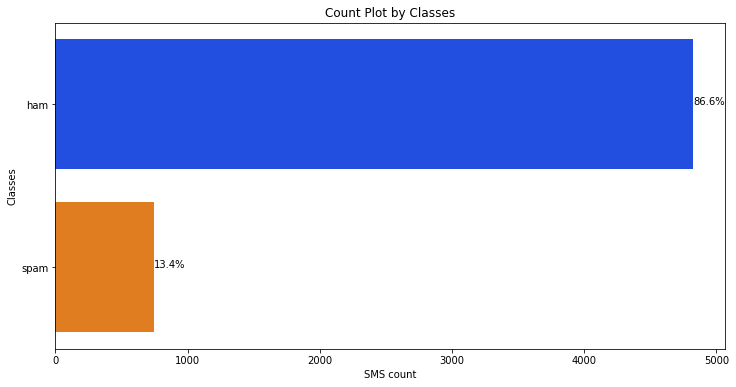

In [51]:
plt.figure(figsize = (12,6))
fg = sns.countplot(y = df["class"], palette='bright')
fg.set_title("Count Plot by Classes")
fg.set_xlabel("SMS count")
fg.set_ylabel("Classes")

total = len(df)

for p in fg.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        fg.annotate(percentage, (x, y))

plt.show()

### NLTK feafures 

Using The Natural Language Toolkit to define the number of characters, words, and sentences.

In [130]:
# need to download punctuations from nltk library
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [131]:
df["characters"] = df["text"].apply(len)
df["words"]=df.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1).apply(len)
df["sentences"]=df.apply(lambda row: nltk.sent_tokenize(row["text"]), axis=1).apply(len)

df.head()

,class,text,characters,words,sentences,clean_text,token_text,nostopwords_text,final_text
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]",ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...",free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]",u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]",nah think goes usf lives around though


In [132]:
# see the statistical informations of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
class,5572.0,0.134063,0.340751,0.0,0.0,0.0,0.0,1.0
characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
words,5572.0,18.501256,13.637056,1.0,9.0,15.0,27.0,219.0
sentences,5572.0,1.991565,1.501427,1.0,1.0,1.5,2.0,38.0


<Figure size 864x576 with 0 Axes>

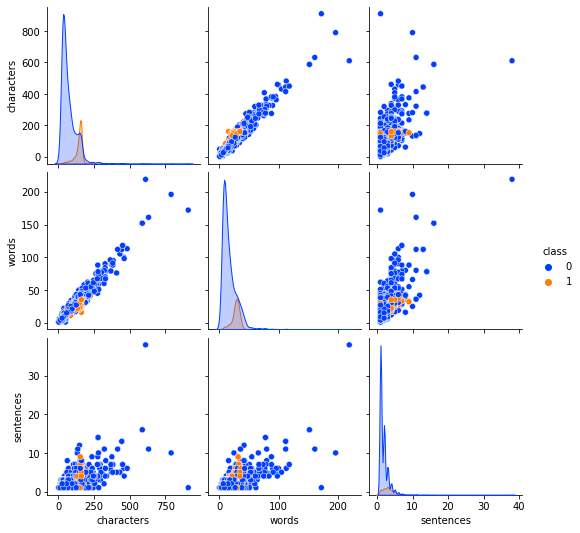

In [133]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="class",palette='bright')
plt.show(fg)

### Cleaning text

In the dataset, text column includes special characters, and non-alphabetic characters. For the better accuracy the should be clean.

In [110]:
print(*df["text"][:10], sep = "\n")

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though
FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
Even my brother is not like to speak with me. They treat me like aids patent.
As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Had your mobile 11 months or more? U R enti

In [79]:
def Clean(Text):
    #using regular expression to remove not necessary characters and make lowercase
    clean_text = re.sub('[^a-zA-Z]', ' ', Text).lower()
    return ' '.join(clean_text.split()) #remove multiple whitespaces into single and return

In [109]:
df["clean_text"] = df["text"].apply(Clean)
print(*df["clean_text"][:10], sep = "\n")

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though
freemsg hey there darling it s been week s now and no word back i d like some fun you up for it still tb ok xxx std chgs to send to rcv
even my brother is not like to speak with me they treat me like aids patent
as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press to copy your friends callertune
winner as a valued network customer you have been selected to receivea prize reward to claim call claim code kl valid hours only
had your mobile months or more u r entitled to update to the latest colour mobiles with camera for free call the mobile update co free on


### Token set 

Our clean text should be tokenized for removing stopwords (not necessary information for model training)

In [104]:
df["token_text"]=df.apply(lambda row: nltk.word_tokenize(row["clean_text"]), axis=1)
print(*df["token_text"][:10], sep = "\n")

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']
['freemsg', 'hey', 'there', 'darling', 'it', 's', 'been', 'week', 's', 'now', 'and', 'no', 'word', 'back', 'i', 'd', 'like', 'some', 'fun', 'you', 'up', 'for', 'it', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'to', 'send', 'to', 'rcv']
['even', 'my', 'brother', 'is', 'not', 'like', 'to', 'speak', 'with', 'me', 'they', 'treat', 'me', 'like', 'aids', 'patent']
['as', 'per', 'your', 'request',

### Remove stopwords

 

In [107]:
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')

In [96]:
eng_stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

These words are not make sense for the training section and it should be removed for the better accuracy of the models.

In [108]:
def remove_eng_stopwords(Text):
  return [word for word in Text if word not in eng_stopwords]

df["nostopwords_text"] = df["token_text"].apply(remove_eng_stopwords)
print(*df["nostopwords_text"][:10], sep = "\n")

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']
['freemsg', 'hey', 'darling', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'rcv']
['even', 'brother', 'like', 'speak', 'treat', 'like', 'aids', 'patent']
['per', 'request', 'melle', 'melle', 'oru', 'minnaminunginte', 'nurungu', 'vettam', 'set', 'callertune', 'callers', 'press', 'copy', 'friends', 'callertune']
['winner', 'valued', 'network', 'customer', 'selected', 'receivea', 'prize', 'reward', 'claim', 'call', 'claim', 'code', 'kl', 'valid', 'hours']
['mobile', 'months', 'u', 'r', '

### Make vector and Label Encoding

In [113]:
def Combine(Text):        
    return ' '.join(Text)

df["final_text"] = df["nostopwords_text"].apply(Combine)

In [127]:
#Transform text data into number vectors
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df["final_text"]).toarray()
print(X.dtype)
print(X.shape)

float64
(5572, 7542)


In [122]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
df["class"] = label_encoder.fit_transform(df["class"])

In [125]:
df.head()

,class,text,characters,words,sentences,clean_text,token_text,nostopwords_text,final_text
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]",ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...",free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]",u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]",nah think goes usf lives around though


## MODEL BUILDING 

Spliting train (70%) and test data (30%) 

In [128]:
y = df["class"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [129]:
print(X_train.shape)
print(X_test.shape)

(3900, 7542)
(1672, 7542)


### Naive Bayes Classifier

Source: https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

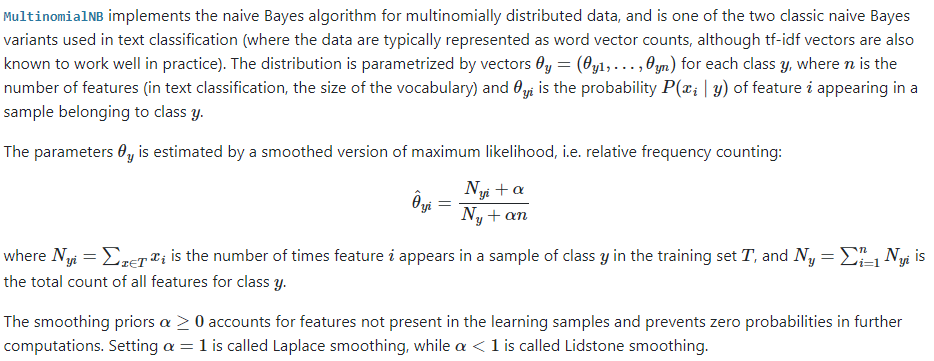

In [176]:
#alpha: float, default=1.0
#fit_prior: bool, default=True

model_MNB = MultinomialNB(alpha=0.5)
model_MNB.fit(X_train, y_train)
predict_MNB = model_MNB.predict(X_test)

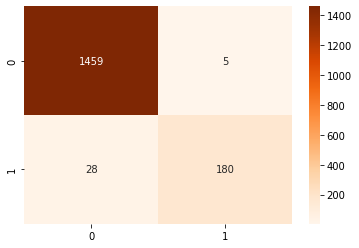

In [177]:
cm_MNB = confusion_matrix(y_test, predict_MNB)
sns.heatmap(cm_MNB, annot=True, fmt='d', cmap='Oranges') 

In [178]:
print(classification_report(y_test, predict_MNB))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1464
           1       0.97      0.87      0.92       208

    accuracy                           0.98      1672
   macro avg       0.98      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672



In [179]:
accuracy_MNB = model_MNB.score(X_test, y_test)
precision_score_MNB = metrics.precision_score(y_test, predict_MNB)
recall_score_MNB = metrics.recall_score(y_test, predict_MNB)
f1_score_MNB = metrics.f1_score(y_test, predict_MNB)

### Random Forest Classifier
Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.



In [180]:
#n_estimators: int, default=100

model_RFS = RandomForestClassifier(n_estimators=50)
model_RFS.fit(X_train, y_train)
predict_RFS = model_RFS.predict(X_test)

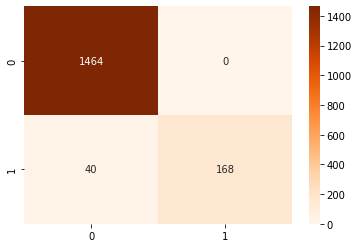

In [181]:
cm_RFS = confusion_matrix(y_test, predict_RFS)
sns.heatmap(cm_RFS, annot=True, fmt='d', cmap='Oranges')

In [175]:
print(classification_report(y_test, predict_RFS))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1464
           1       1.00      0.80      0.89       208

    accuracy                           0.98      1672
   macro avg       0.99      0.90      0.94      1672
weighted avg       0.98      0.98      0.97      1672



In [169]:
accuracy_RFS = model_RFS.score(X_test, y_test)
precision_score_RFS = metrics.precision_score(y_test, predict_RFS)
recall_score_RFS = metrics.recall_score(y_test, predict_RFS)
f1_score_RFS = metrics.f1_score(y_test, predict_RFS)

In [ ]:
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [ ]:
# Cossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.967552 
RandomForest: 0.976790 
KNeighbours: 0.911450 
SVC: 0.974086 


## Compare Models

 

Testing the models on Testset

Accuracy Report
Confusion Matrix

In [ ]:
# Model Evaluation
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [ ]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [ ]:
Results.style.background_gradient(cmap='coolwarm')

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.705882,0.827586,0.974775,0.997521
RandomForest,1.000000,0.808824,0.894309,0.974775,0.997521
KNeighbours,0.977778,0.323529,0.486188,0.974775,0.997521
SVC,0.990909,0.801471,0.886179,0.974775,0.997521


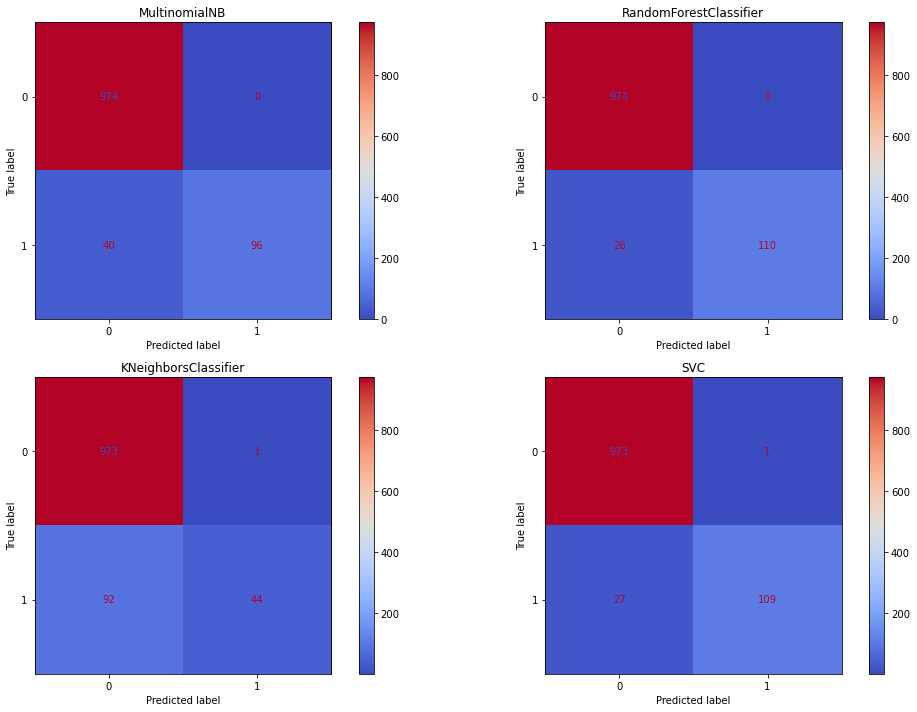

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap= 'coolwarm',   
                          )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

MultinomialNB()

In [ ]:
import pickle

In [ ]:
pickle.dump(classifiers[0], open('SpamDetectorModelNB.pkl', 'wb'))
pickle.dump(tfidf, open('Vectorizer.pkl', 'wb'))

In [ ]:
pickled_model = pickle.load(open('SpamDetectorModelNB.pkl', 'rb'))
pickled_model.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
data

{'Precision': [1.0, 1.0, 0.9777777777777777, 0.990909090909091],
 'Recall': [0.7058823529411765,
  0.8088235294117647,
  0.3235294117647059,
  0.8014705882352942],
 'F1score': [0.8275862068965517,
  0.8943089430894309,
  0.4861878453038674,
  0.8861788617886179],
 'Accuracy on Testset': [0.9747747747747748,
  0.9747747747747748,
  0.9747747747747748,
  0.9747747747747748],
 'Accuracy on Trainset': [0.9975214060387562,
  0.9975214060387562,
  0.9975214060387562,
  0.9975214060387562]}